#### Torch CNN - CIFAR10

In [1]:
import PIL
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

import os, sys
from pathlib import Path
sys.path.append(str(Path('.ipynb').resolve().parents[2]))

BATCH_SIZE = 128
DOWNLOAD = False
SUBSET = 0

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load dataset
train_dataset = torchvision.datasets.CIFAR10(root='/home/tung5534/cnn_cifar/data', 
                                            train=True,
                                            download=DOWNLOAD,
                                            transform=train_transform,
                                            )
test_dataset = torchvision.datasets.CIFAR10(root='/home/tung5534/cnn_cifar/data', 
                                            train=False,
                                            download=DOWNLOAD,
                                            transform=test_transform,
                                            )
if SUBSET != 0:
    subset_indices = list(range(SUBSET))
    train_set = torch.utils.data.Subset(train_dataset, subset_indices)
    test_set = torch.utils.data.Subset(test_dataset, subset_indices)
    print(f'Using subset of {SUBSET} samples')
else:
    train_set, test_set = train_dataset, test_dataset
    print('Using full dataset')

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Class names
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Using full dataset
cuda


In [2]:
def save_performance(save_path,
                     train_losses, test_losses, train_errs, 
                     test_errs, train_accs, test_acc, run_times,
                     n_step):
    import os
    import json

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if n_step < 1:
        lr = str(n_step).replace(".","")
        
    performance = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_errs': train_errs,
        'test_errs': test_errs,
        'train_accs': train_accs,
        'test_acc': test_acc,
        'run_time': run_times,
        'n_step': n_step
    }
    with open(f'{save_path}/FISTA_5steps_lr_{n_step}.json', 'w') as f:
        json.dump(performance, f, indent=4)    

In [3]:
def evaluate_model(model, criterion, test_loader=test_loader):
    model.eval()
    _test_acc, _test_err, _test_loss, total_test = 0, 0, 0, 0
    
    with torch.no_grad():
        for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                _test_acc += (predicted == labels).sum().item()
                _test_err += (predicted != labels).sum().item()
                _test_loss += criterion(outputs, labels).item()

    test_loss = _test_loss / total_test
    test_err = 100 * _test_err / total_test
    test_acc = 100 * _test_acc / total_test

    return test_loss, test_err, test_acc

In [4]:
# import torch
# from torch.optim.optimizer import Optimizer

# class FISTA(Optimizer):
#     def __init__(self, params, lr=1e-3, ministeps = 5):
#         defaults = dict(lr=lr, ministeps=ministeps)
#         super(FISTA, self).__init__(params, defaults)

#         for group in self.param_groups:
#             group['y'] = [p.clone().detach() for p in group['params']]
#             group['k'] = 1

#     def step(self, closure=None):
#         if closure is None:
#             raise RuntimeError("FISTA requires a closure to recompute gradients.")
        
#         loss = None
#         for group in self.param_groups:
#             lr, ministeps = group['lr'], group['ministeps']

#             # Loop over ministeps
#             for _ in range(ministeps):
# #                 k = group['k']
#                 k = 1

#                 with torch.enable_grad():
#                     loss = closure()

#                 # Reset, k=1, update p
#                 for i, p in enumerate(group['params']):
#                     if p.grad is None:
#                         continue

#                     x_k = p.data
#                     y_k = group['y'][i].data

#                     # y_k grad
#                     grad_y = p.grad.data

#                     # x_{k+1} = y_k - t * grad(f(y_k))
#                     x_next = y_k - lr * grad_y
#                     # Question: Should we update multi-step here, inside the loop

#                     #  y_{k+1} = x_{k+1} + (k / (k + 3)) * (x_{k+1} - x_k)
#                     momentum_coeff = (k) / (k + 3)
#                     y_next = x_next + momentum_coeff * (x_next - x_k)

#                     # Update
#                     p.data = x_next
#                     group['y'][i].data = y_next
            
# #             group['k'] += 1

#         return loss


In [5]:
import time
from models import SimpleCNN
from optim.fista_multi_wo_prox import FISTA

def modeling(n_epochs=100, lr=0.01, threshold=90, n_step=5):
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = FISTA(model.parameters(), lr=lr, ministeps=n_step)
    
    train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = [], [], [], [], [], [], []

    for i, epoch in enumerate(range(n_epochs)):
        print(f"Epoch: {i+1}/{n_epochs}")
        model.train() 
        total_train, _train_err, _train_acc, running_loss, run_time = 0, 0, 0, 0.0, 0
        _start = time.time()

        def closure():
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            return loss

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward
            optimizer.zero_grad()
            outputs = model(images)
            # Backward
            loss = optimizer.step(closure)

            # Log Losses and Training accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            _train_err += (predicted != labels).sum().item()
            _train_acc += (predicted == labels).sum().item()

        run_time = time.time() - _start
        
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = 100 * _train_acc / total_train
        epoch_train_err = 100 * _train_err / total_train
        
        test_loss, test_err, test_acc = evaluate_model(model, criterion, test_loader)

        train_losses.append(epoch_train_loss)
        train_errs.append(epoch_train_err)
        train_accs.append(epoch_train_acc)
        test_losses.append(test_loss)
        test_errs.append(test_err)
        test_accs.append(test_acc)
        run_times.append(run_time)

        if epoch % 1 == 0:
            print(f'E [{epoch+1}/{n_epochs}]. train_loss_acc: {running_loss / len(train_loader):.4f}, {epoch_train_acc:.2f}%, '
                    f'test_acc: {test_acc:.2f}%, run_time: {round(run_time, 2)} seconds')
        if epoch_train_acc >= threshold:
            print(f"Early stopping at epoch {epoch+1} with train error {epoch_train_err:.2f}%")
            break
    return train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times

Epoch: 1/30
E [1/30]. train_loss_acc: 1.1938, 48.14%, test_acc: 58.43%, run_time: 8.79 seconds
Epoch: 2/30
E [2/30]. train_loss_acc: 0.7082, 63.26%, test_acc: 69.40%, run_time: 8.53 seconds
Epoch: 3/30
E [3/30]. train_loss_acc: 0.5090, 69.60%, test_acc: 73.53%, run_time: 8.52 seconds
Epoch: 4/30
E [4/30]. train_loss_acc: 0.3975, 72.76%, test_acc: 74.23%, run_time: 8.53 seconds
Epoch: 5/30
E [5/30]. train_loss_acc: 0.3223, 75.30%, test_acc: 76.56%, run_time: 8.56 seconds
Epoch: 6/30
E [6/30]. train_loss_acc: 0.2655, 77.46%, test_acc: 77.39%, run_time: 8.54 seconds
Epoch: 7/30
E [7/30]. train_loss_acc: 0.2274, 78.61%, test_acc: 79.28%, run_time: 8.54 seconds
Epoch: 8/30
E [8/30]. train_loss_acc: 0.1973, 79.95%, test_acc: 79.98%, run_time: 8.56 seconds
Epoch: 9/30
E [9/30]. train_loss_acc: 0.1738, 80.79%, test_acc: 79.91%, run_time: 8.56 seconds
Epoch: 10/30
E [10/30]. train_loss_acc: 0.1509, 81.93%, test_acc: 80.92%, run_time: 8.55 seconds
Epoch: 11/30
E [11/30]. train_loss_acc: 0.1312, 

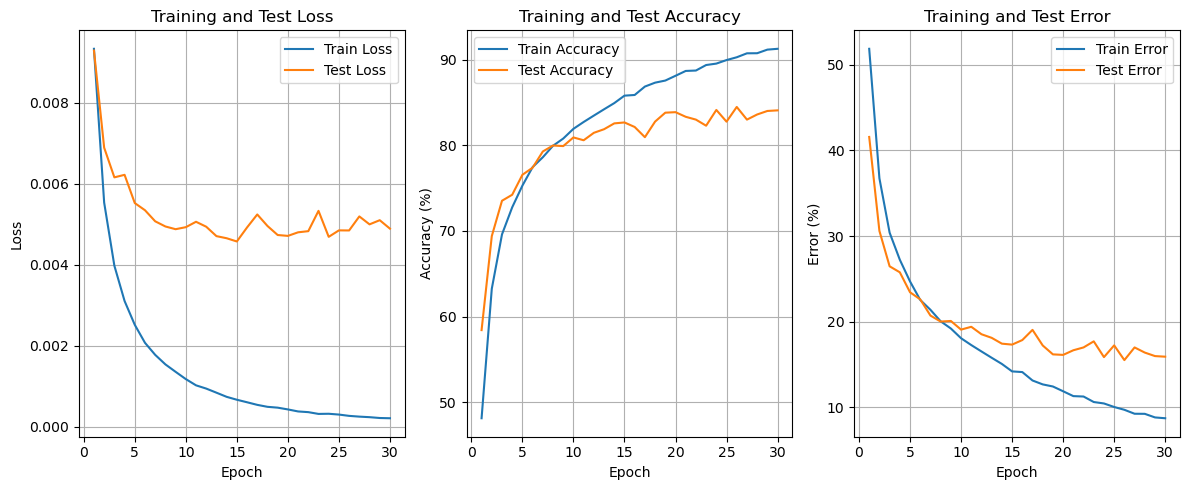

Epoch: 1/30
E [1/30]. train_loss_acc: 0.8309, 51.50%, test_acc: 63.86%, run_time: 9.38 seconds
Epoch: 2/30
E [2/30]. train_loss_acc: 0.2787, 65.87%, test_acc: 70.75%, run_time: 9.34 seconds
Epoch: 3/30
E [3/30]. train_loss_acc: 0.1518, 70.78%, test_acc: 72.11%, run_time: 9.34 seconds
Epoch: 4/30
E [4/30]. train_loss_acc: 0.1021, 74.08%, test_acc: 77.09%, run_time: 9.31 seconds
Epoch: 5/30
E [5/30]. train_loss_acc: 0.0776, 75.97%, test_acc: 76.55%, run_time: 9.31 seconds
Epoch: 6/30
E [6/30]. train_loss_acc: 0.0601, 77.94%, test_acc: 77.58%, run_time: 9.33 seconds
Epoch: 7/30
E [7/30]. train_loss_acc: 0.0501, 79.34%, test_acc: 78.68%, run_time: 9.35 seconds
Epoch: 8/30
E [8/30]. train_loss_acc: 0.0444, 80.32%, test_acc: 76.82%, run_time: 9.33 seconds
Epoch: 9/30
E [9/30]. train_loss_acc: 0.0383, 81.54%, test_acc: 79.81%, run_time: 9.35 seconds
Epoch: 10/30
E [10/30]. train_loss_acc: 0.0325, 82.66%, test_acc: 81.03%, run_time: 9.35 seconds
Epoch: 11/30
E [11/30]. train_loss_acc: 0.0289, 

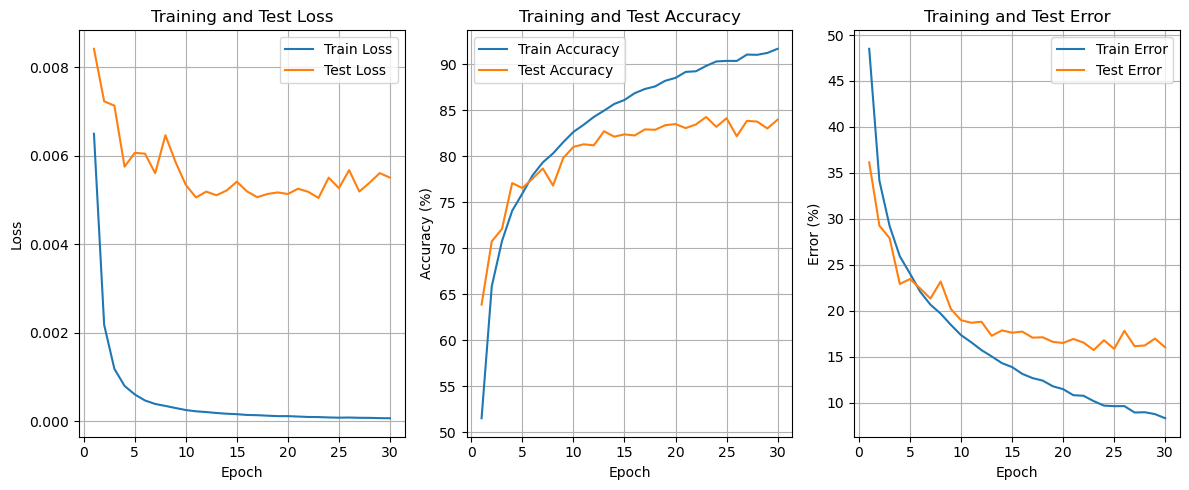

Epoch: 1/30
E [1/30]. train_loss_acc: 0.2890, 53.71%, test_acc: 67.82%, run_time: 10.84 seconds
Epoch: 2/30
E [2/30]. train_loss_acc: 0.0397, 67.26%, test_acc: 70.30%, run_time: 10.83 seconds
Epoch: 3/30
E [3/30]. train_loss_acc: 0.0274, 71.41%, test_acc: 72.43%, run_time: 10.83 seconds
Epoch: 4/30
E [4/30]. train_loss_acc: 0.0218, 74.54%, test_acc: 75.58%, run_time: 10.85 seconds
Epoch: 5/30
E [5/30]. train_loss_acc: 0.0181, 76.62%, test_acc: 78.05%, run_time: 10.83 seconds
Epoch: 6/30
E [6/30]. train_loss_acc: 0.0156, 78.33%, test_acc: 77.64%, run_time: 10.82 seconds
Epoch: 7/30
E [7/30]. train_loss_acc: 0.0141, 79.76%, test_acc: 78.22%, run_time: 10.83 seconds
Epoch: 8/30
E [8/30]. train_loss_acc: 0.0124, 81.17%, test_acc: 79.17%, run_time: 10.85 seconds
Epoch: 9/30
E [9/30]. train_loss_acc: 0.0113, 81.93%, test_acc: 80.25%, run_time: 10.83 seconds
Epoch: 10/30
E [10/30]. train_loss_acc: 0.0104, 82.85%, test_acc: 81.34%, run_time: 10.82 seconds
Epoch: 11/30
E [11/30]. train_loss_acc

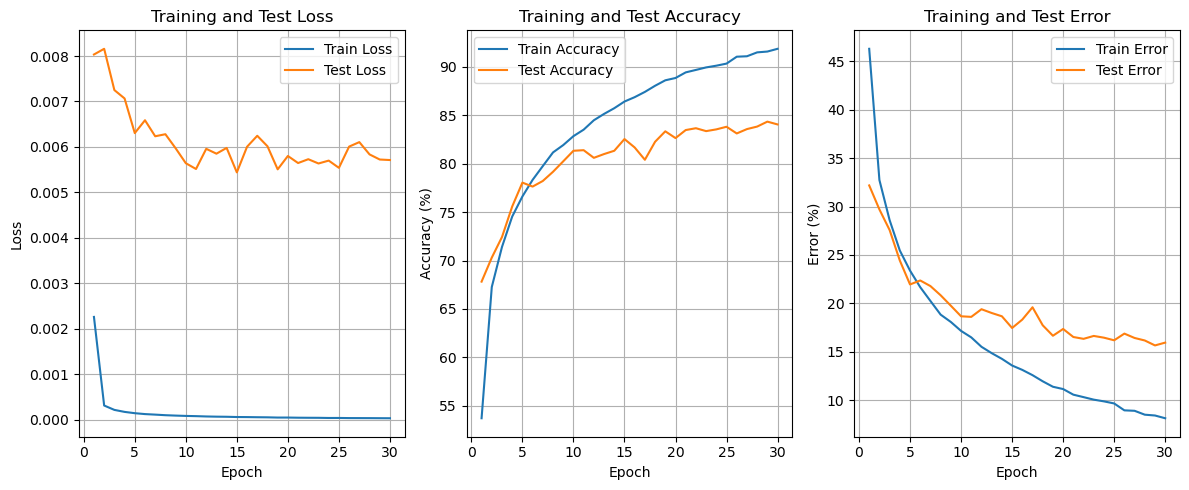

Epoch: 1/30
E [1/30]. train_loss_acc: 0.0995, 53.92%, test_acc: 66.67%, run_time: 13.09 seconds
Epoch: 2/30
E [2/30]. train_loss_acc: 0.0159, 66.46%, test_acc: 71.05%, run_time: 13.03 seconds
Epoch: 3/30
E [3/30]. train_loss_acc: 0.0121, 71.23%, test_acc: 72.34%, run_time: 13.06 seconds
Epoch: 4/30
E [4/30]. train_loss_acc: 0.0101, 74.52%, test_acc: 74.16%, run_time: 13.12 seconds
Epoch: 5/30
E [5/30]. train_loss_acc: 0.0088, 76.41%, test_acc: 76.93%, run_time: 13.09 seconds
Epoch: 6/30
E [6/30]. train_loss_acc: 0.0081, 77.92%, test_acc: 76.86%, run_time: 13.06 seconds
Epoch: 7/30
E [7/30]. train_loss_acc: 0.0073, 79.24%, test_acc: 78.88%, run_time: 13.08 seconds
Epoch: 8/30
E [8/30]. train_loss_acc: 0.0066, 80.54%, test_acc: 79.67%, run_time: 13.07 seconds
Epoch: 9/30
E [9/30]. train_loss_acc: 0.0062, 81.60%, test_acc: 80.34%, run_time: 13.08 seconds
Epoch: 10/30
E [10/30]. train_loss_acc: 0.0057, 82.87%, test_acc: 80.30%, run_time: 13.14 seconds
Epoch: 11/30
E [11/30]. train_loss_acc

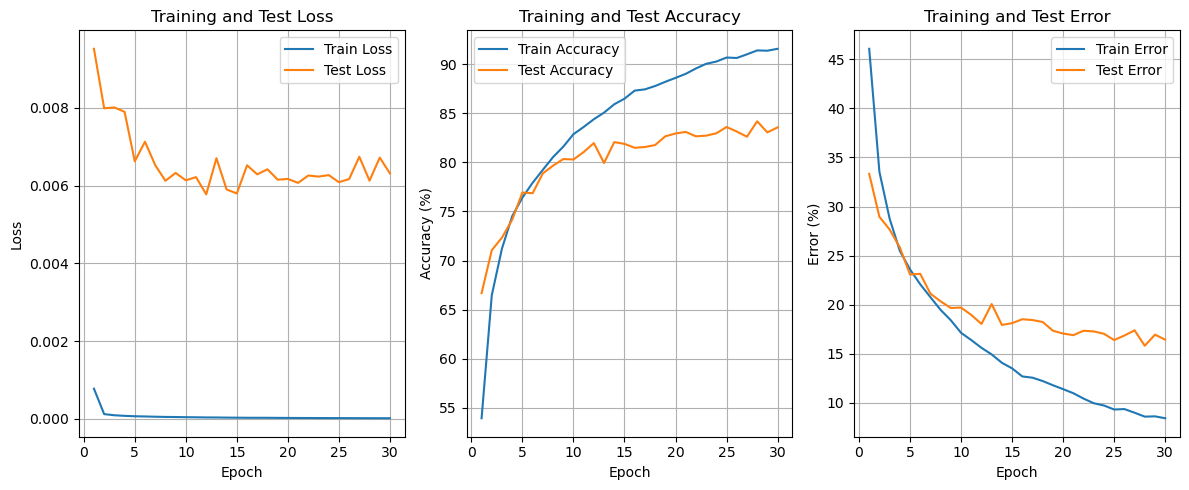

Epoch: 1/30
E [1/30]. train_loss_acc: 0.0739, 52.12%, test_acc: 65.34%, run_time: 14.6 seconds
Epoch: 2/30
E [2/30]. train_loss_acc: 0.0121, 65.15%, test_acc: 68.80%, run_time: 14.55 seconds
Epoch: 3/30
E [3/30]. train_loss_acc: 0.0095, 70.09%, test_acc: 73.73%, run_time: 14.55 seconds
Epoch: 4/30
E [4/30]. train_loss_acc: 0.0081, 73.42%, test_acc: 75.39%, run_time: 14.66 seconds
Epoch: 5/30
E [5/30]. train_loss_acc: 0.0071, 75.77%, test_acc: 75.78%, run_time: 14.62 seconds
Epoch: 6/30
E [6/30]. train_loss_acc: 0.0064, 77.39%, test_acc: 77.70%, run_time: 14.56 seconds
Epoch: 7/30
E [7/30]. train_loss_acc: 0.0058, 78.71%, test_acc: 76.52%, run_time: 14.6 seconds
Epoch: 8/30
E [8/30]. train_loss_acc: 0.0055, 80.13%, test_acc: 78.47%, run_time: 14.56 seconds
Epoch: 9/30
E [9/30]. train_loss_acc: 0.0051, 81.16%, test_acc: 78.83%, run_time: 14.57 seconds
Epoch: 10/30
E [10/30]. train_loss_acc: 0.0048, 82.09%, test_acc: 79.33%, run_time: 14.66 seconds
Epoch: 11/30
E [11/30]. train_loss_acc: 

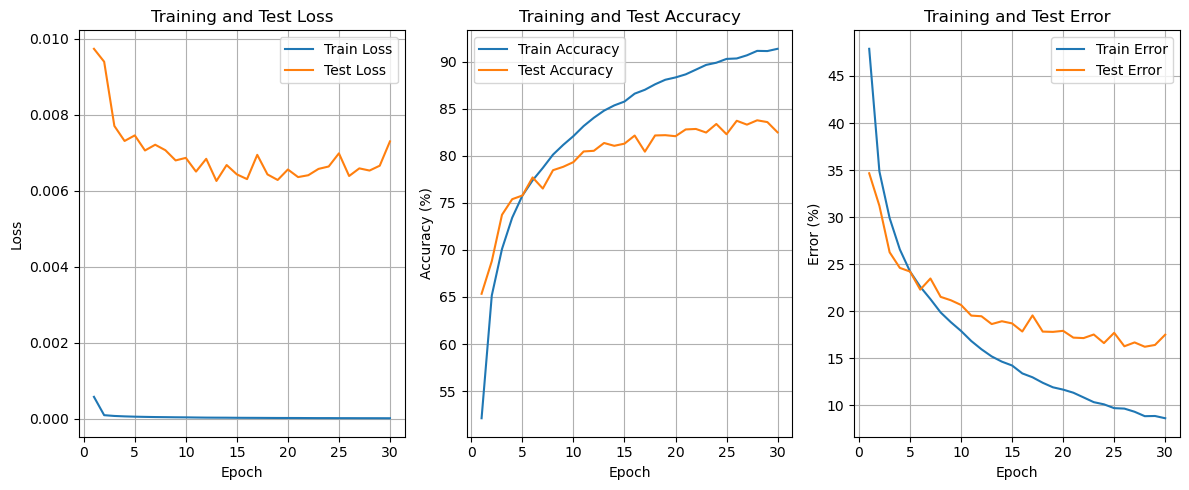

In [6]:
import numpy as np
from plot import metrics_plot

n_steps = [2, 3, 5, 8, 10]
n_epochs = 30
threshold = 100
lr = 0.055
for n_step in n_steps:
    train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = modeling(n_epochs=n_epochs,
                                                                                              lr=lr,
                                                                                              threshold=threshold,
                                                                                              n_step=n_step
                                                                                             )
    save_path = f'scores/E30_ministeps_lr055'
    save_performance(save_path,
                     train_losses, test_losses, train_errs, 
                     test_errs, train_accs, test_accs, run_times, n_step=lr,
                     )
    actual_nepochs = len(train_losses)
    metrics_plot(actual_nepochs, train_losses, test_losses, train_accs, test_accs, train_errs, test_errs)

### Plot performance

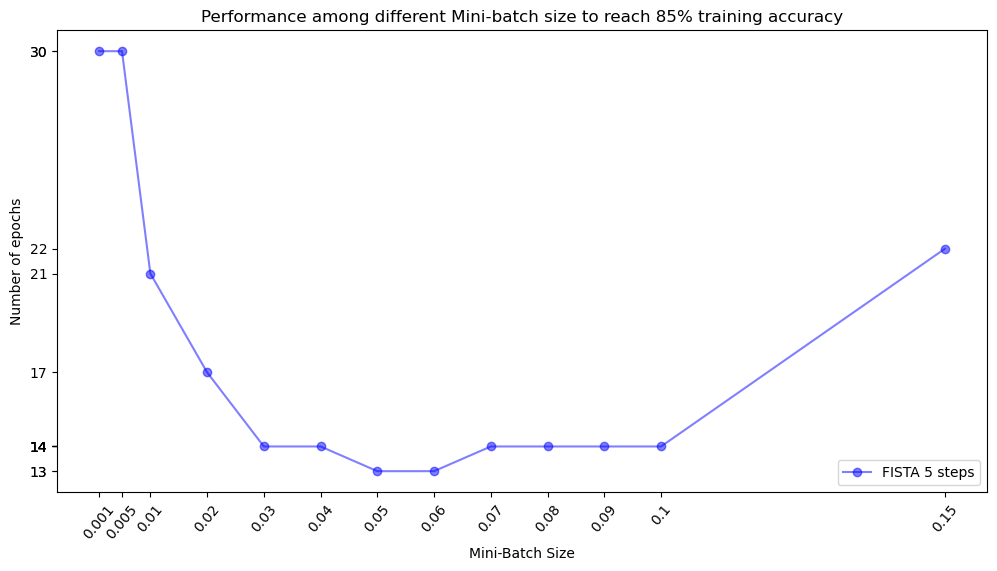

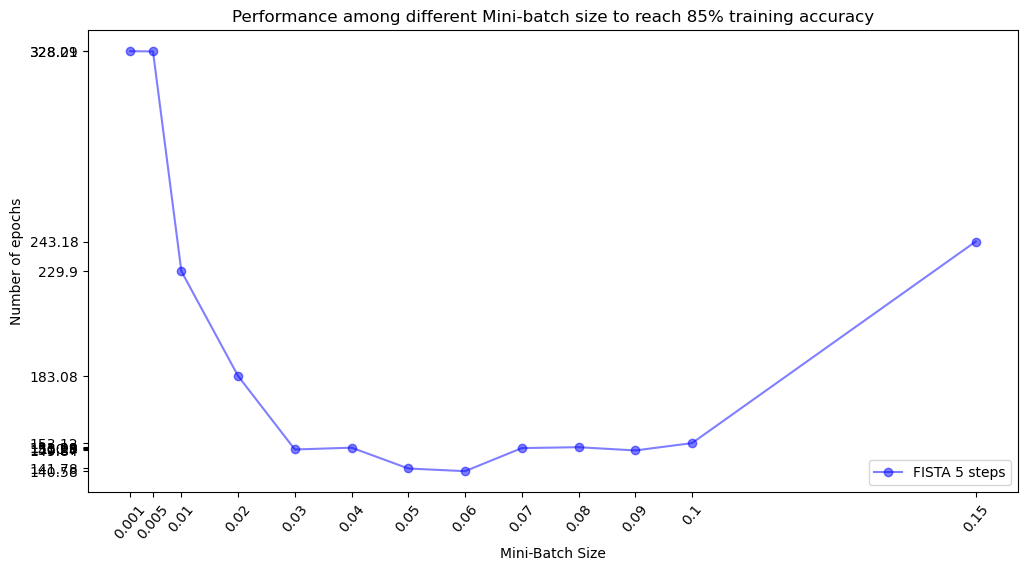

In [20]:
import os, json
import matplotlib.pyplot as plt

def load_performance(score_path):
    epochs = {}
    run_times = {}
    for root, dirs, files in os.walk(score_path):
        for file in files:
            if file.endswith('.json') and file.startswith('FISTA_'):
                if file.endswith('checkpoint.json'):
                    pass
                else:
                    with open(root+file, 'r') as f:
                        data = json.load(f)
                        lr = data['n_step']
                        n_epoch = len(data['train_losses'])
                        run_times[lr] = sum(data['run_time'])
                        epochs[lr] = n_epoch
    lrs = sorted(list(epochs.keys()))
    n_epochs = [epochs[k] for k in lrs]
    _run_time = [round(run_times[k], 2) for k in lrs]
    return lrs, n_epochs, _run_time

score_path_1 = "/home/tung5534/cnn_cifar/W08/fista_multi/scores/E30_ministeps_lr055/"
batch_sizes_5steps, n_epochs_5steps, run_time_5steps = load_performance(score_path_1)


plt.figure(figsize=(12,6))
plt.plot(batch_sizes_5steps, n_epochs_5steps, marker='o', color='b', alpha=.5, label='FISTA 5 steps')
plt.xlabel('Mini-Batch Size')
plt.xticks(batch_sizes_5steps, labels=batch_sizes_5steps, rotation=50)
plt.ylabel('Number of epochs')
y_tickslabel = n_epochs_3steps
plt.yticks(y_tickslabel, labels=y_tickslabel, rotation=0)
plt.title('Performance among different Mini-batch size to reach 85% training accuracy')
plt.legend(loc= 'lower right')
# plt.grid()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(batch_sizes_5steps, run_time_5steps, marker='o', color='b', alpha=.5, label='FISTA 5 steps')
plt.xlabel('Mini-Batch Size')
plt.xticks(batch_sizes_5steps, labels=batch_sizes_5steps, rotation=50)
plt.ylabel('Number of epochs')
y_tickslabel = run_time_5steps
plt.yticks(y_tickslabel, labels=y_tickslabel, rotation=0)
plt.title('Performance among different Mini-batch size to reach 85% training accuracy')
plt.legend(loc= 'lower right')
# plt.grid()
plt.show()

**Optimal Step size for FISTA 5steps is 0.055**